<h1>Capital One Data Challenge: Card Transaction</h1>
<li>Name: Xiaoyi Wang
<li>Candidate ID: C1562077
<li>Version of Submission: v20.01

In [15]:
import random
import numpy as np
import pandas as pd
import datetime
import pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import roc_curve,auc

<h2>Q1 load</h2>
<h3>read json to pandas dataframe</h3>

In [19]:
#Q1 load
#read json to pandas dataframe
url = 'https://github.com/CapitalOneRecruiting/DS/blob/master/transactions.zip?raw=true'
data = pd.read_json(url,lines=True,compression='zip')

<h3>The structure and basic info of the data</h3>

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
accountNumber               786363 non-null int64
customerId                  786363 non-null int64
creditLimit                 786363 non-null int64
availableMoney              786363 non-null float64
transactionDateTime         786363 non-null object
transactionAmount           786363 non-null float64
merchantName                786363 non-null object
acqCountry                  786363 non-null object
merchantCountryCode         786363 non-null object
posEntryMode                786363 non-null object
posConditionCode            786363 non-null object
merchantCategoryCode        786363 non-null object
currentExpDate              786363 non-null object
accountOpenDate             786363 non-null object
dateOfLastAddressChange     786363 non-null object
cardCVV                     786363 non-null int64
enteredCVV                  786363 non-null int64
cardLast4Digits          

<h3>Basic summary statistics for each fields</h3>
<li>A count of null

In [298]:
data=data.replace('', np.nan)
data.isnull().sum()
#echoBuffer, merchantCity, merchantState, merchantZip, posOnPremises, recurringAuthInd are all null

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

In [25]:
#convert transactionDateTime, currentExpDate, accountOpenDate, dateOfLastAddressChange columns to datetime type
data['transactionDateTime']=data['transactionDateTime'].astype({"transactionDateTime":"datetime64"})
data['currentExpDate']=data['currentExpDate'].astype({"currentExpDate":"datetime64"}).dt.to_period('M')
data['accountOpenDate']=data['accountOpenDate'].astype({"accountOpenDate":"datetime64"}).dt.to_period('D')
data['dateOfLastAddressChange']=data['dateOfLastAddressChange'].astype({"dateOfLastAddressChange":"datetime64"}).dt.to_period('D')

<li>Maximum and minimum values in appropriate columns

In [6]:
#Maximum values
data[['creditLimit','availableMoney','transactionDateTime','transactionAmount','currentExpDate','accountOpenDate',
      'dateOfLastAddressChange','currentBalance']].max()

creditLimit                              50000
availableMoney                           50000
transactionDateTime        2016-12-30 23:59:45
transactionAmount                      2011.54
currentExpDate                         2033-08
accountOpenDate                     2015-12-31
dateOfLastAddressChange             2016-12-30
currentBalance                         47498.8
dtype: object

In [7]:
#Minimum values
data[['creditLimit','availableMoney','transactionDateTime','transactionAmount','currentExpDate','accountOpenDate',
      'dateOfLastAddressChange','currentBalance']].min()

creditLimit                                250
availableMoney                        -1005.63
transactionDateTime        2016-01-01 00:01:02
transactionAmount                            0
currentExpDate                         2019-12
accountOpenDate                     1989-08-22
dateOfLastAddressChange             1989-08-22
currentBalance                               0
dtype: object

<li>Statistic description for numerical variables

In [8]:
data[['creditLimit','availableMoney','transactionAmount','currentBalance']].describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


<li>The number of unique values in all columns

In [300]:
for i in data.columns:
    print(i, data[i].unique().size)

accountNumber 5000
customerId 5000
creditLimit 10
availableMoney 521915
transactionDateTime 776637
transactionAmount 66038
merchantName 2490
acqCountry 5
merchantCountryCode 5
posEntryMode 6
posConditionCode 4
merchantCategoryCode 19
currentExpDate 165
accountOpenDate 1820
dateOfLastAddressChange 2184
cardCVV 899
enteredCVV 976
cardLast4Digits 5245
transactionType 4
echoBuffer 1
currentBalance 487318
merchantCity 1
merchantState 1
merchantZip 1
cardPresent 2
posOnPremises 1
recurringAuthInd 1
expirationDateKeyInMatch 2
isFraud 2


In [9]:
#examples of unique values in appropriate columns
for i in data.columns:
    if 2 < data[i].unique().size < 20:
        print(i, data[i].unique())

creditLimit [ 5000  2500 50000 15000 10000   250   500  1000  7500 20000]
acqCountry ['US' nan 'CAN' 'MEX' 'PR']
merchantCountryCode ['US' 'CAN' nan 'PR' 'MEX']
posEntryMode ['02' '09' '05' '80' '90' nan]
posConditionCode ['01' '08' '99' nan]
merchantCategoryCode ['rideshare' 'entertainment' 'mobileapps' 'fastfood' 'food_delivery'
 'auto' 'online_retail' 'gym' 'health' 'personal care' 'food' 'fuel'
 'online_subscriptions' 'online_gifts' 'hotels' 'airline' 'furniture'
 'subscriptions' 'cable/phone']
transactionType ['PURCHASE' 'ADDRESS_VERIFICATION' 'REVERSAL' nan]


<h3>Basic cleaning</h3>
<li>Drop the columns where values are all null

In [26]:
data=data.drop(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], axis=1)

<li>Drop one of accountNumber and customerId because these two columns are just the same

In [27]:
print('the number of transaction where account number and customer id are different', data[data['accountNumber']!=data['customerId']].shape[0])
data=data.drop(['accountNumber'],axis=1)

the number of transaction where account number and customer id are different 0


In [28]:
data

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,5000,5000.00,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,...,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.00,False,False,False
1,737265056,5000,5000.00,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,True,False,False
2,737265056,5000,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,False,False,False
3,737265056,5000,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,False,False,False
4,830329091,5000,5000.00,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,...,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.00,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,50000,48904.96,2016-12-22 18:44:12,119.92,Lyft,US,US,90,01,...,2012-08-23,2012-08-23,936,936,3783,PURCHASE,1095.04,False,False,False
786359,732852505,50000,48785.04,2016-12-25 16:20:34,18.89,hulu.com,US,US,09,01,...,2012-08-23,2012-08-23,939,939,3388,PURCHASE,1214.96,False,False,False
786360,732852505,50000,48766.15,2016-12-27 15:46:24,49.43,Lyft,US,US,02,01,...,2012-08-23,2012-08-23,936,936,3783,PURCHASE,1233.85,False,False,False
786361,732852505,50000,48716.72,2016-12-29 00:30:55,49.89,walmart.com,US,US,09,99,...,2012-08-23,2012-08-23,939,939,3388,PURCHASE,1283.28,False,False,False


<h2>Q2 plot</h2>
<h3>The histogram of transactionAmount</h3>

Text(0, 0.5, 'Probability')

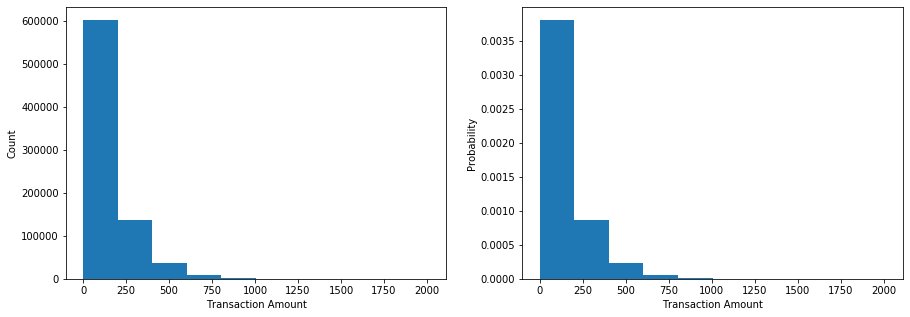

In [33]:
grid = gridspec.GridSpec(1, 2)
plt.figure(figsize=(15,5))
ax1 = plt.subplot(grid[0])
plt.hist(data['transactionAmount'],bins=10,density=False)
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
ax2 = plt.subplot(grid[1])
plt.hist(data['transactionAmount'],bins=10,density=True)
plt.xlabel('Transaction Amount')
plt.ylabel('Probability')

<h3>The feature of the structure</h3>
<li>The histogram skews to the left and has a long tail on the right
<li>Most of the Transaction amount are very small, but there are a few amount very large

<h3>Hypotheses: the distribution of transaction amount follows log-normal distribution</h3>
<li>Conduct log transformation on the transaction amount
<li>There are 22225 zero transaction amount, the number is very small compare to the 786363 in total

In [42]:
data[data['transactionAmount']==0]['transactionAmount'].size

22225

<li>Plot the histogram of log non-zero transaction amount

<function matplotlib.pyplot.show(*args, **kw)>

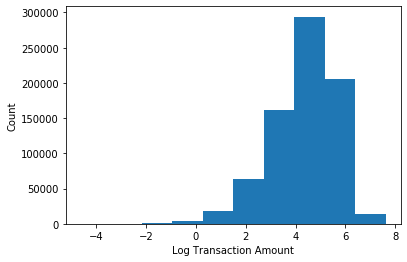

In [41]:
plt.hist(np.log(data[data['transactionAmount']>0]['transactionAmount']),bins=10,density=False)
plt.xlabel('Log Transaction Amount')
plt.ylabel('Count')
plt.show

<h3>Some other plots about the data</h3>
<li>The sum of transaction amount everyday

/Users/wxy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


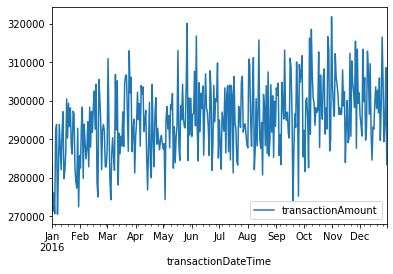

In [123]:
data1=data[['transactionDateTime','transactionAmount']]
data1['transactionDateTime']=data1['transactionDateTime'].dt.to_period('D')
amount_per_day=data1.groupby('transactionDateTime').sum()
pd.DataFrame(amount_per_day).plot()

<li>The amount and time distribution of fraud transactions

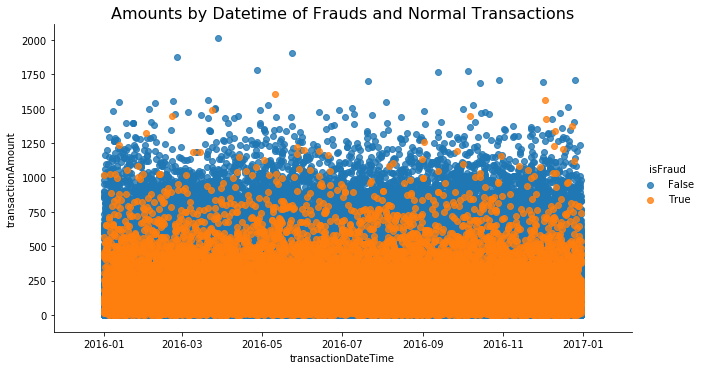

In [303]:
ax = sns.lmplot(y="transactionAmount", x="transactionDateTime", fit_reg=False,aspect=1.8,
                data=data, hue='isFraud')
plt.title("Amounts by Datetime of Frauds and Normal Transactions",fontsize=16)
plt.show()

<li>Correlation between features

Text(0.5, 1, 'Correlation between features')

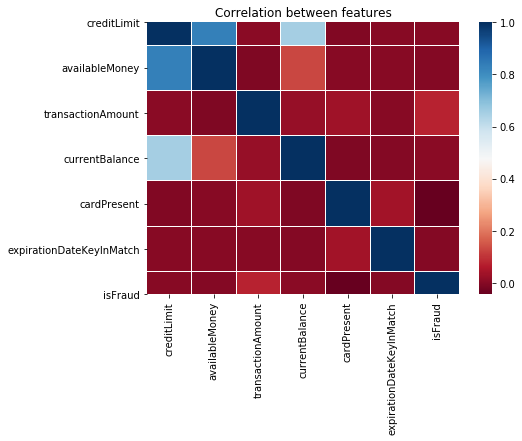

In [44]:
corr = data[['creditLimit','availableMoney','transactionAmount','currentBalance','cardPresent','expirationDateKeyInMatch','isFraud']].corr()
f, ax= plt.subplots(figsize = (7, 5))
sns.heatmap(corr,cmap='RdBu', linewidths = 0.05, ax = ax)
ax.set_title('Correlation between features')

<li>The number of transaction in each category

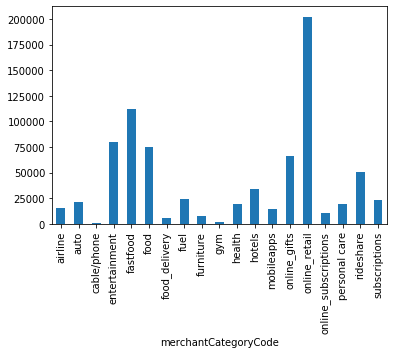

In [132]:
category_group = data.groupby('merchantCategoryCode')
category_group.size().plot(kind='bar')

<h2>Q3 Data Wrangling - Duplicate Transactions</h2>
<h3>Identify reversed and multi-swipe transactions</h3>
<li>Reversed type

In [53]:
reversal_type = data[data['transactionType']=='REVERSAL']
reversal_transaction = pd.DataFrame(columns=data.columns)
for t in reversal_type.iterrows():
    c = data.iloc[t[0]-1]
    if (c['customerId']==t[1]['customerId']) and (c['transactionAmount']==t[1]['transactionAmount']) and (c['merchantName']==t[1]['merchantName']) and (c['cardLast4Digits']==t[1]['cardLast4Digits']) and (c['transactionType']=='PURCHASE'):
        reversal_transaction = reversal_transaction.append(t[1])

<li>Multi-swipe type

In [70]:
#Multi-swipe type
purchase_type = data[data['transactionType']=='PURCHASE']
purchase_type['Duplicate']=purchase_type.duplicated(['customerId','merchantName', 'cardLast4Digits'])
duplicate_purchase=purchase_type[purchase_type['Duplicate']==True]

/Users/wxy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [88]:
multiswipe_transaction = pd.DataFrame(columns=data.columns)
for t in duplicate_purchase.iterrows():
    c = data.loc[t[0]-1]
    if (c['customerId']==t[1]['customerId']) and (c['merchantName']==t[1]['merchantName']) and (t[1]['transactionDateTime']-c['transactionDateTime']<np.timedelta64(1,'h')):
        multiswipe_transaction = multiswipe_transaction.append(t[1])

<h3>Number and amount of both types of duplicate transaction</h3>
<li>Reversed type

In [91]:
print('total number of reversed transactions is', int(reversal_transaction.shape[0]))
print('total dollar amount of reversed transactions is', reversal_transaction['transactionAmount'].sum())

total number of reversed transactions is 6063
total dollar amount of reversed transactions is 907959.35


<li>Multi-swipe type

In [90]:
print('total number of multi-swipe transactions is', int(multiswipe_transaction.shape[0]))
print('total dollar amount of multi-swipe transactions is', multiswipe_transaction['transactionAmount'].sum())

total number of multi-swipe transactions is 14176
total dollar amount of multi-swipe transactions is 2108171.99


<h3>Interesting findings</h3>
<li>Transaction Amount

Text(0, 0.5, 'Count')

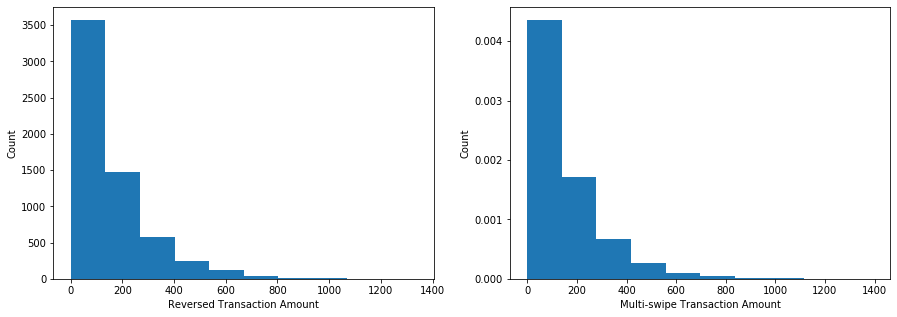

In [95]:
grid = gridspec.GridSpec(1, 2)
plt.figure(figsize=(15,5))
ax1 = plt.subplot(grid[0])
plt.hist(reversal_transaction['transactionAmount'],bins=10,density=False)
plt.xlabel('Reversed Transaction Amount')
plt.ylabel('Count')
ax2 = plt.subplot(grid[1])
plt.hist(multiswipe_transaction['transactionAmount'],bins=10,density=True)
plt.xlabel('Multi-swipe Transaction Amount')
plt.ylabel('Count')

In [94]:
reversal_transaction['transactionAmount'].describe()

count    6063.000000
mean      149.754140
std       152.186442
min         0.090000
25%        41.055000
50%       104.670000
75%       204.010000
max      1338.250000
Name: transactionAmount, dtype: float64

In [93]:
multiswipe_transaction['transactionAmount'].describe()

count    14176.000000
mean       148.714164
std        149.081214
min          0.000000
25%         42.327500
50%        103.415000
75%        205.560000
max       1394.190000
Name: transactionAmount, dtype: float64

<li>Card Present

Text(0, 0.5, 'Count')

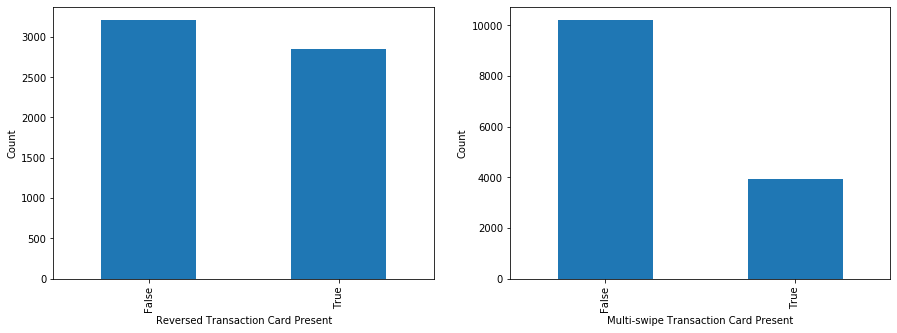

In [99]:
grid = gridspec.GridSpec(1, 2)
plt.figure(figsize=(15,5))
ax1 = plt.subplot(grid[0])
reversal_transaction.groupby('cardPresent').size().plot(kind='bar')
plt.xlabel('Reversed Transaction Card Present')
plt.ylabel('Count')
ax2 = plt.subplot(grid[1])
multiswipe_transaction.groupby('cardPresent').size().plot(kind='bar')
plt.xlabel('Multi-swipe Transaction Card Present')
plt.ylabel('Count')

<li>Fraud

Text(0, 0.5, 'Count')

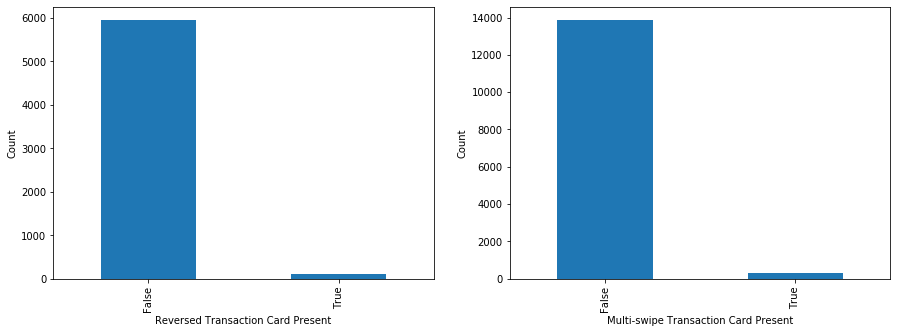

In [100]:
grid = gridspec.GridSpec(1, 2)
plt.figure(figsize=(15,5))
ax1 = plt.subplot(grid[0])
reversal_transaction.groupby('isFraud').size().plot(kind='bar')
plt.xlabel('Reversed Transaction Card Present')
plt.ylabel('Count')
ax2 = plt.subplot(grid[1])
multiswipe_transaction.groupby('isFraud').size().plot(kind='bar')
plt.xlabel('Multi-swipe Transaction Card Present')
plt.ylabel('Count')

In [104]:
all_fraud_rate = 100*data[data['isFraud']].shape[0]/data.shape[0]
re_fraud_rate = 100*reversal_transaction[reversal_transaction['isFraud']].shape[0]/reversal_transaction.shape[0]
mu_fraud_rate = 100*multiswipe_transaction[multiswipe_transaction['isFraud']].shape[0]/multiswipe_transaction.shape[0]
print('The percent of fraud transaction in all data is',all_fraud_rate)
print('The percent of fraud transaction in reversed duplicate transaction is',re_fraud_rate)
print('The percent of fraud transaction in multi-swipe duplicate transaction is',mu_fraud_rate)

The percent of fraud transaction in all data is 1.579041740264992
The percent of fraud transaction in reversed duplicate transaction is 1.764802902853373
The percent of fraud transaction in multi-swipe duplicate transaction is 2.0950902934537248


<h2>Q4 Model</h2>
<h3>Data Cleaning</h3>
<li>Split x and y

In [106]:
data1=data
data1['currentExpDate']=data1['currentExpDate'].apply(lambda x:x.to_timestamp())
data1['accountOpenDate']=data1['accountOpenDate'].apply(lambda x:x.to_timestamp())
data1['dateOfLastAddressChange']=data1['dateOfLastAddressChange'].apply(lambda x:x.to_timestamp())

In [145]:
data_y=data1.iloc[:,[-1]]
data_x=data1.iloc[:,0:-1]

<li>Missing values

In [146]:
data_x = data_x.replace(np.nan, 'Other')

<li>Datetime columns

/Users/wxy/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'dateOfLastAddressChange')

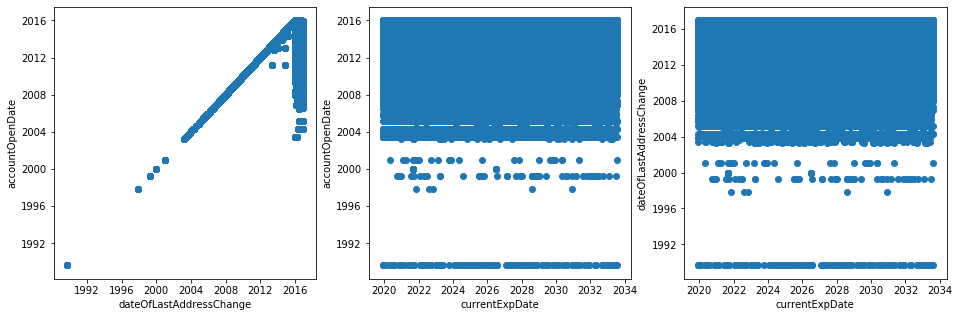

In [15]:
grid = gridspec.GridSpec(1, 3)
plt.figure(figsize=(16,5))
ax1 = plt.subplot(grid[0])
plt.scatter(data1['dateOfLastAddressChange'],data1['accountOpenDate'])
ax1.set_ylabel('accountOpenDate')
ax1.set_xlabel('dateOfLastAddressChange')
ax2 = plt.subplot(grid[1])
plt.scatter(data1['currentExpDate'],data1['accountOpenDate'])
ax2.set_xlabel('currentExpDate')
ax2.set_ylabel('accountOpenDate')
ax3 = plt.subplot(grid[2])
plt.scatter(data1['currentExpDate'],data1['dateOfLastAddressChange'])
ax3.set_xlabel('currentExpDate')
ax3.set_ylabel('dateOfLastAddressChange')
#accountOpenDate and dateOfLastAddressChange are highly correlated
#drop the column of dateOfLastAddressChange

In [147]:
#extract month, day, hour, minute from transactionDateTime, then drop transactionDateTime
data_x['transactionMonth']=data_x['transactionDateTime'].dt.month
data_x['transactionDay']=data_x['transactionDateTime'].dt.day
data_x['transactionHour']=data_x['transactionDateTime'].dt.hour
data_x['transactionMinute']=data_x['transactionDateTime'].dt.minute
data_x=data_x.drop(['transactionDateTime'],axis=1)

In [148]:
#covert currentExpDate to the number of month from 2016-12 till expire
data_x['monthTillExp']=data_x['currentExpDate'].apply(lambda x: (x-pd.Timestamp('2016-12-31')).days/30)
#covert accountOpenDate to the number of month since account open till 2016-12
data_x['accountExistMonth']=data_x['accountOpenDate'].apply(lambda x: (pd.Timestamp('2016-12-31')-x).days/30)
#cover dateOfLastAddressChange to the number of month since address change till 2016-12
data_x['addressKeepMonth']=data_x['dateOfLastAddressChange'].apply(lambda x: (pd.Timestamp('2016-12-31')-x).days/30)
data_x=data_x.drop(['currentExpDate','accountOpenDate','dateOfLastAddressChange'],axis=1)

<li>merchantName

In [149]:
#covert merchantName to a boolean value of whether the merchant is the first time appear on one's card
data_x['purchasedMerchant'] = data_x.duplicated(['customerId', 'merchantName', 'cardLast4Digits'])

In [150]:
#covert merchantName to a Boolean value of whether the merchant has been appear in the all the transactions less than 10 times
merchant_count = data_x['merchantName'].value_counts()
merchant_count.quantile(.02)

9.0

In [151]:
data_x['unpopularMerchant'] = data_x['merchantName'].apply(lambda x: merchant_count[x]<10)

<li>Country

In [211]:
#convert merchantCountryCode to dummy variable
data_x1=data_x
merchantCountryCode=pd.get_dummies(data_x1['merchantCountryCode'], prefix='merchantCountryCode', prefix_sep='_', drop_first=False)
data_x1=pd.concat([data_x1,merchantCountryCode], axis=1)

In [212]:
#Add a boolean column 'inPRorMEX' to see the merchant is in PR or MEX
data_x1['inPRorMEX']= (data_x1['merchantCountryCode_MEX']==1)|(data_x1['merchantCountryCode_PR']==1)

In [213]:
#Add a boolean column 'sameCountry' to see the transaction and card acquired country is same or not
data_x1['sameCountry'] = data_x1['acqCountry'] == data_x1['merchantCountryCode']

<li>posEntryMode, posConditionCode, merchantCategoryCode and transactionType

In [214]:
posEntryMode=pd.get_dummies(data_x1['posEntryMode'], prefix='posEntryMode', prefix_sep='_', drop_first=False)
data_x1=pd.concat([data_x1,posEntryMode], axis=1)

posConditionCode=pd.get_dummies(data_x['posConditionCode'], prefix='posConditionCode', prefix_sep='_', drop_first=False)
data_x1=pd.concat([data_x1,posConditionCode], axis=1)

merchantCategoryCode=pd.get_dummies(data_x['merchantCategoryCode'], prefix='merchantCategoryCode', prefix_sep='_', drop_first=False)
data_x1=pd.concat([data_x1,merchantCategoryCode], axis=1)

transactionType=pd.get_dummies(data_x['transactionType'], prefix='transactionType', prefix_sep='_', drop_first=False)
data_x1=pd.concat([data_x1,transactionType], axis=1)

<li>CVV

In [215]:
#Convert 'cardCVV' and 'enteredCVV' to a Boolean value of whether the 2 number is matched
data_x1['CVVMatch']= data_x1['cardCVV']==data_x1['enteredCVV']

<li>Active

In [216]:
#Add a column to show if the card is active
data_x1['active']=data_x1['currentBalance']/data_x1['creditLimit']

<li>Duplicate Transactions

In [217]:
#Add column 'reversedDuplicate' to see whether the transaction is reversed duplicate
data_x2=data_x1
data_x2['reversedDuplicate'] = False
data_x2['reversedDuplicate'] = data_x2.loc[reversal_transaction.index]['reversedDuplicate'].apply(lambda x: True)
data_x2['reversedDuplicate'] = data_x2['reversedDuplicate'].replace(np.nan, False)

In [218]:
#Add column 'multiswipeDuplicate' to see whether the transaction is reversed duplicate
data_x2['multiswipeDuplicate'] = False
data_x2['multiswipeDuplicate'] = data_x2.loc[multiswipe_transaction.index]['multiswipeDuplicate'].apply(lambda x: True)
data_x2['multiswipeDuplicate'] = data_x2['multiswipeDuplicate'].replace(np.nan, False)

In [219]:
#Add column 'eitherDuplicate' to see whether the transaction is either one of the two kinds of duplicate
data_x2['eitherDuplicate'] = (data_x2['reversedDuplicate'] == True) | (data_x2['multiswipeDuplicate'] == True)

<li>drop some irelevent or duplicated features

In [220]:
sel_x=data_x2.drop(['customerId','merchantName','acqCountry','merchantCountryCode','posEntryMode',
                    'posConditionCode','merchantCategoryCode', 'transactionType','cardLast4Digits','cardCVV',
                    'enteredCVV'],axis=1)

In [221]:
sel_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 60 columns):
creditLimit                                  786363 non-null int64
availableMoney                               786363 non-null float64
transactionAmount                            786363 non-null float64
currentBalance                               786363 non-null float64
cardPresent                                  786363 non-null bool
expirationDateKeyInMatch                     786363 non-null bool
transactionMonth                             786363 non-null int64
transactionDay                               786363 non-null int64
transactionHour                              786363 non-null int64
transactionMinute                            786363 non-null int64
monthTillExp                                 786363 non-null float64
accountExistMonth                            786363 non-null float64
addressKeepMonth                             786363 non-null float64
purchase

<h3>Search differents distribuitions of features</h3>

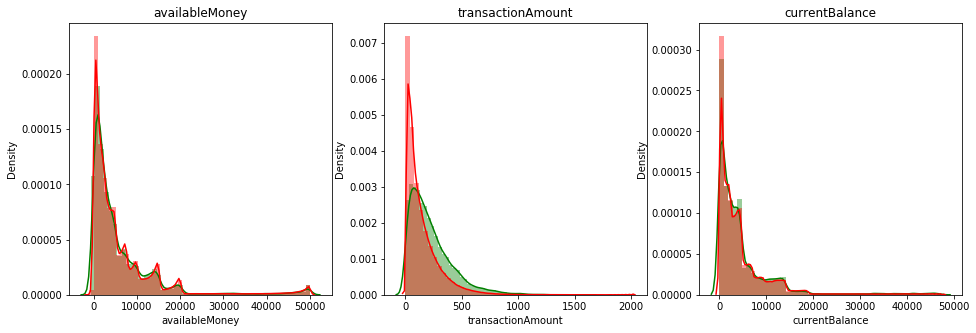

In [222]:
frauds = data_y.isFraud == True
normals = data_y.isFraud == False

grid = gridspec.GridSpec(1, 3)
plt.figure(figsize=(16,5))

column = ['availableMoney', 'transactionAmount', 'currentBalance']

for col in column:
    ax1 = plt.subplot(grid[column.index(col)])
    sns.distplot(sel_x[col][frauds], color='g')
    sns.distplot(sel_x[col][normals], color='r')
    ax1.set_ylabel('Density')
    ax1.set_title(col)

plt.show()

<h3>Divide train and test set</h3>

In [226]:
train_x, test_x, train_y, test_y=train_test_split(sel_x, data_y, test_size=0.3,random_state=0)

<h3>Using random over sampling to handle imbalance</h3>

In [260]:
ros = RandomOverSampler(random_state=0)
ros_x, ros_y = ros.fit_resample(train_x, train_y)

<h3>Feature selection based on Feature Importance</h3>

In [261]:
feature_names = [key for key in ros_x]
model = RandomForestClassifier(max_depth=10,min_samples_split=100,n_estimators=50).fit(ros_x, np.ravel(ros_y))
importances = model.feature_importances_
feat_import = pd.DataFrame({'Feature': feature_names, 'Feature importance': importances})

In [262]:
#25 most important features selected by Feature Importance
sel_feat = feat_import['Feature'][0:25].ravel()
sel_feat

array(['creditLimit', 'availableMoney', 'transactionAmount',
       'currentBalance', 'cardPresent', 'expirationDateKeyInMatch',
       'transactionMonth', 'transactionDay', 'transactionHour',
       'transactionMinute', 'monthTillExp', 'accountExistMonth',
       'addressKeepMonth', 'purchasedMerchant', 'unpopularMerchant',
       'merchantCountryCode_CAN', 'merchantCountryCode_MEX',
       'merchantCountryCode_Other', 'merchantCountryCode_PR',
       'merchantCountryCode_US', 'inPRorMEX', 'sameCountry',
       'posEntryMode_02', 'posEntryMode_05', 'posEntryMode_09'],
      dtype=object)

In [264]:
sel_ros_x = ros_x[sel_feat]
sel_test_x = test_x[sel_feat]

<h3>Modeling</h3>

In [224]:
def evaluate_model(valid_y, pred_y):
    rf_cm = confusion_matrix(valid_y, pred_y)
    tp, fn, fp, tn = rf_cm.ravel()
    accuracy = (tn+tp)/(tn+fp+fn+tp)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f_score = precision*recall/(precision+recall)*2
    roc_auc = roc_auc_score(valid_y, pred_y)
    model_score = {'f_score':f_score, 'roc_auc':roc_auc, 'accuracy':accuracy, 'precision':precision, 'recall':recall}
    return model_score

<li>Decision Tree

In [265]:
dt_model = DecisionTreeClassifier(max_depth=15,min_samples_split=10,criterion='entropy',random_state=0)
dt_model.fit(sel_ros_x, np.ravel(ros_y))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [268]:
accuracy_score(ros_y, dt_model.predict(sel_ros_x))

0.8050627186383733

In [291]:
dt_pred_y = dt_model.predict(sel_test_x)
dt_cm = confusion_matrix(test_y, dt_pred_y)

In [270]:
dt_eva = evaluate_model(test_y, dt_pred_y)
dt_eva

{'f_score': 0.8256874744182425,
 'roc_auc': 0.6380384120119045,
 'accuracy': 0.705746707416843,
 'precision': 0.9904573714395875,
 'recall': 0.7079197902179202}

In [271]:
(dt_fpr, dt_tpr, dt_thresholds) = roc_curve(test_y, dt_pred_y)
dt_area = auc(dt_fpr,dt_tpr)

<li>Random Forest

In [272]:
rf_model = RandomForestClassifier(max_depth=10,min_samples_split=10,n_estimators=50,criterion='entropy',random_state=0)
rf_model.fit(sel_ros_x, np.ravel(ros_y))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [282]:
accuracy_score(ros_y, rf_model.predict(sel_ros_x))

0.7428231232866597

In [290]:
rf_pred_y = rf_model.predict(sel_test_x)
rf_cm = confusion_matrix(test_y, rf_pred_y)

In [275]:
rf_eva = evaluate_model(test_y, rf_pred_y)
rf_eva

{'f_score': 0.8631852960138184,
 'roc_auc': 0.6910997561726071,
 'accuracy': 0.7616157077517178,
 'precision': 0.9921701975347308,
 'recall': 0.7638789016581913}

In [276]:
(rf_fpr, rf_tpr, rf_thresholds) = roc_curve(test_y, rf_pred_y)
rf_area = auc(rf_fpr,rf_tpr)

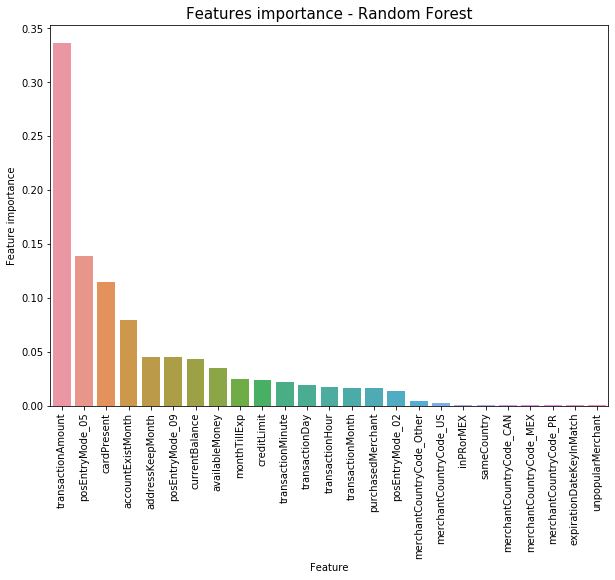

In [277]:
#feature importance in random forest moedel
feature_names = [key for key in sel_ros_x]
importances = rf_model.feature_importances_
feat_import = pd.DataFrame({'Feature': feature_names, 'Feature importance': importances})
feat_import = feat_import.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize=(10,7))
g = sns.barplot(x='Feature',y='Feature importance',data=feat_import)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('Features importance - Random Forest',fontsize=15)
plt.show() 

<li>Grandient Boosting

In [278]:
gdb_model = GradientBoostingClassifier(max_depth=10,n_estimators=50,min_samples_split=10,random_state=0)
gdb_model.fit(sel_ros_x, np.ravel(ros_y))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [281]:
accuracy_score(ros_y, gdb_model.predict(sel_ros_x))

0.8830728902262301

In [285]:
gdb_pred_y = gdb_model.predict(sel_test_x)
gdb_cm = confusion_matrix(test_y, gdb_pred_y)

In [288]:
gdb_eva = evaluate_model(test_y, gdb_pred_y)
gdb_eva

{'f_score': 0.897298087304169,
 'roc_auc': 0.6845666966576671,
 'accuracy': 0.8153186186198915,
 'precision': 0.9913948025023831,
 'recall': 0.8195150727046473}

In [289]:
(gdb_fpr, gdb_tpr, gdb_thresholds) = roc_curve(test_y, gdb_pred_y)
gdb_area = auc(gdb_fpr,gdb_tpr)

<h3>Model comparison</h3>
<li>ROC curve

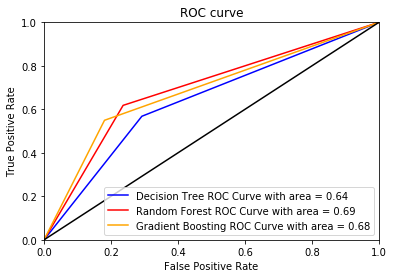

In [292]:
pl.clf()
pl.plot(dt_fpr,dt_tpr,label="Decision Tree ROC Curve with area = %1.2f"%dt_area,color='blue')
pl.plot(rf_fpr,rf_tpr,label="Random Forest ROC Curve with area = %1.2f"%rf_area,color='red')
pl.plot(gdb_fpr,gdb_tpr,label="Gradient Boosting ROC Curve with area = %1.2f"%gdb_area,color='orange')

pl.plot([0, 1], [0, 1], 'k')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('ROC curve')
pl.legend(loc="lower right")
pl.show()

<li>Evaluation Indicators

In [293]:
evaluation = pd.DataFrame([dt_eva.values(),rf_eva.values(),gdb_eva.values()],
                     index=['Decision Tree','Random Forest','Gradient Boosting'],
                      columns=dt_eva.keys())
evaluation

,f_score,roc_auc,accuracy,precision,recall
Decision Tree,0.825687,0.638038,0.705747,0.990457,0.707920
Random Forest,0.863185,0.691100,0.761616,0.992170,0.763879
Gradient Boosting,0.897298,0.684567,0.815319,0.991395,0.819515
